# Scan LSST aerosols during 10 years

- Author :Sylvie Dagoret-Campagne
- affiliation : LAL,IN2P3,CNRS
- organization : LSST 

- creation : Tuesday 2nd May 2016
- update : Wednesday 18th May 2016

Plot aerosols and humidity versus years 
Show histograms and fit several functions


In [1]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import h5py
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import libCaliopAOD as cal

In [2]:
import air
import humidity as hum

In [3]:
#from __future__ import print_function
import datetime
from matplotlib.dates import YearLocator,MonthLocator, WeekdayLocator,DateFormatter
from matplotlib.dates import MONDAY

In [4]:
mondays = WeekdayLocator(MONDAY)
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")

In [5]:
years= YearLocator()
yearsFmt=DateFormatter("%Y")

In [6]:
year_start=2007   # choose the month number
year_stop=2015   # choose the month number
month_start=0      # choose first month
month_stop=11      # choose last month
month_numbers=np.arange(month_start,month_stop+1)
month_stringnumber=['01','02','03','04','05','06','07','08','09','10','11','12']

In [7]:
nb_of_years=year_stop-year_start+1                               # number of years   
number_of_monthes_per_year=month_numbers.shape[0]               # number of months per year
total_number_of_monthes=number_of_monthes_per_year*nb_of_years  # total number of monthes over years

### defines constants

In [8]:
data_dates=np.array(datetime.date(year_start,month_start+1,1))

In [9]:
#path_root='/Volumes/DAGORETBACK/CALIPSO/DATA/ICARE/CALIOP/L3/CAL_LID_L3_APro_CloudFree.v3.00/CAL_LID_L3_APro_CloudFree.v3.00'
path_root='/Volumes/DAGORETBACK/CALIPSO/DATA/ICARE/CALIOP/L3/CAL_LID_L3_APro_CloudFree.v3.00/CAL_LID_L3_APro_CloudySkyTransparent.v3.00'
fullpath_root=os.path.join(os.path.join(path_root,str(2007)),'hdf5')
#filename_base='CAL_LID_L3_APro_CloudFree-Standard-V3-00' 
filename_base='CAL_LID_L3_APro_CloudySkyTransparent-Standard-V3-00' 

In [10]:
# /Volumes/DAGORETBACK/CALIPSO/DATA/ICARE/CALIOP/L3/CAL_LID_L3_APro_CloudFree.v3.00/CAL_LID_L3_APro_CloudySkyTransparent.v3.00/2007/hdf5

dayfile_fullname=cal.GetL3FilenameDay(path_root,filename_base,year_start,month_start)
nightfile_fullname=cal.GetL3FilenameNight(path_root,filename_base,year_start,month_start)
dayfiles_fullname=np.array(dayfile_fullname)
nightfiles_fullname=np.array(nightfile_fullname)

print 'first day file = ', dayfile_fullname
print 'first night file = ', nightfile_fullname

first day file =  /Volumes/DAGORETBACK/CALIPSO/DATA/ICARE/CALIOP/L3/CAL_LID_L3_APro_CloudFree.v3.00/CAL_LID_L3_APro_CloudySkyTransparent.v3.00/2007/hdf5/CAL_LID_L3_APro_CloudySkyTransparent-Standard-V3-00.2007-01D.h5
first night file =  /Volumes/DAGORETBACK/CALIPSO/DATA/ICARE/CALIOP/L3/CAL_LID_L3_APro_CloudFree.v3.00/CAL_LID_L3_APro_CloudySkyTransparent.v3.00/2007/hdf5/CAL_LID_L3_APro_CloudySkyTransparent-Standard-V3-00.2007-01N.h5


In [11]:
# initialize the data container for AOD
aod_day_first=cal.GetL3Value(dayfile_fullname,'AOD_Mean')
aod_night_first=cal.GetL3Value(nightfile_fullname,'AOD_Mean')
aod_day_coll=np.array(aod_day_first)
aod_night_coll=np.array(aod_night_first)

In [12]:
# initialize the data container for Humidity during the day
vec_temperatures_day=cal.GetL3Value(dayfile_fullname,'Temperature_Mean') # vector quantities
vec_pressures_day=cal.GetL3Value(dayfile_fullname,'Pressure_Mean')
vec_rhumidity_day=cal.GetL3Value(dayfile_fullname,'Relative_Humidity_Mean')
# initialize the data container for Humidity during the night
vec_temperatures_night=cal.GetL3Value(nightfile_fullname,'Temperature_Mean') # vector quantities
vec_pressures_night=cal.GetL3Value(nightfile_fullname,'Pressure_Mean')
vec_rhumidity_night=cal.GetL3Value(nightfile_fullname,'Relative_Humidity_Mean')
altitudes=cal.GetL3APAltitudes()
thealtitudes=altitudes[0:len(vec_temperatures_day)]

# calculation or precipitable water in each slice during the day
pwv_day=hum.rh2ah(vec_rhumidity_day/100.,vec_pressures_day*100.,vec_temperatures_day+273.)*60. # don't know why need to devide by 10 ???
pwvcut_day=pwv_day
pwvcut_day[np.where(thealtitudes<2.68)]=0
sumpwv_day=np.sum(pwvcut_day)

# calculation or precipitable water in each slice during the night
pwv_night=hum.rh2ah(vec_rhumidity_night/100.,vec_pressures_night*100.,vec_temperatures_night+273.)*60./10 # don't know why need to devide by 10 ???
pwvcut_night=pwv_night
pwvcut_night[np.where(thealtitudes<2.68)]=0
sumpwv_night=np.sum(pwvcut_night)

# define the collections
pwv_day_coll=np.array(sumpwv_day)
pwv_night_coll=np.array(sumpwv_night)

### defines the list of dates and filenames for days and night

In [13]:
for year in range(2007,2016,1):
    fullpath_root=os.path.join(os.path.join(path_root,str(2007)),'hdf5')   
    for month in range(1,13):
        if not (year == 2007 and month ==1):
            # retreive the filename
            newdayfile=cal.GetL3FilenameDay(path_root,filename_base,year,month-1)
            newnightfile=cal.GetL3FilenameNight(path_root,filename_base,year,month-1)
            # extract the AOD value
            newdayaod=cal.GetL3Value(newdayfile,'AOD_Mean')
            newnightaod=cal.GetL3Value(newnightfile,'AOD_Mean')
            # extract the humidity, Temperature and pressure vectors 
            
            # initialize the data container for Humidity during the day
            vec_temperatures_day=cal.GetL3Value(newdayfile,'Temperature_Mean') # vector quantities
            vec_pressures_day=cal.GetL3Value(newdayfile,'Pressure_Mean')
            vec_rhumidity_day=cal.GetL3Value(newdayfile,'Relative_Humidity_Mean')
            # initialize the data container for Humidity during the night
            vec_temperatures_night=cal.GetL3Value(newnightfile,'Temperature_Mean') # vector quantities
            vec_pressures_night=cal.GetL3Value(newnightfile,'Pressure_Mean')
            vec_rhumidity_night=cal.GetL3Value(newnightfile,'Relative_Humidity_Mean')
            
            if(year>=2014 or ( year>=2013 and month>2 )):
                vec_rhumidity_day=vec_rhumidity_day*100.
                vec_rhumidity_night=vec_rhumidity_night*100.
            
            altitudes=cal.GetL3APAltitudes()
            thealtitudes=altitudes[0:len(vec_temperatures_day)]

            # calculation or precipitable water in each slice during the day
            pwv_day=hum.rh2ah(vec_rhumidity_day/100.,vec_pressures_day*100.,vec_temperatures_day+273.)*60. # don't know why need to devide by 10 ???
            pwvcut_day=pwv_day
            pwvcut_day[np.where(thealtitudes<2.68)]=0
            sumpwv_day=np.sum(pwvcut_day)

            # calculation or precipitable water in each slice during the night
            pwv_night=hum.rh2ah(vec_rhumidity_night/100.,vec_pressures_night*100.,vec_temperatures_night+273.)*60. # don't know why need to devide by 10 ???
            pwvcut_night=pwv_night
            pwvcut_night[np.where(thealtitudes<2.68)]=0
            sumpwv_night=np.sum(pwvcut_night)
            
            
            
            # append the filename
            dayfiles_fullname=np.append(dayfiles_fullname,newdayfile)
            nightfiles_fullname=np.append(nightfiles_fullname,newnightfile)
            # append the date
            data_dates= np.append( data_dates , datetime.date(year,month,1))
            # append the AOD
            aod_day_coll=np.append(aod_day_coll,newdayaod)
            aod_night_coll=np.append(aod_night_coll,newnightaod)
            # append the pwv
            pwv_day_coll=np.append(pwv_day_coll,sumpwv_day)
            pwv_night_coll=np.append(pwv_night_coll,sumpwv_night)
            
            

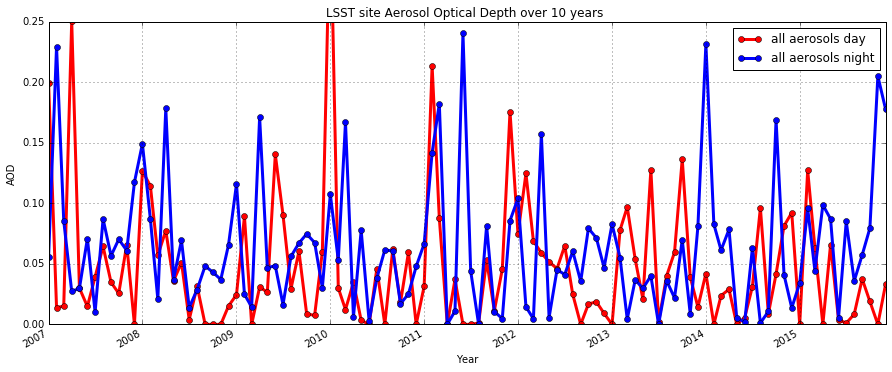

In [14]:
################################################################
# Time sequence for AOD
###############################################################

fig=plt.figure(figsize=(15,6))
ax=fig.add_subplot(1,1,1)


ax.plot_date(data_dates, aod_day_coll,'ro-',label='all aerosols day',linewidth=3)
ax.plot_date(data_dates, aod_night_coll,'bo-',label='all aerosols night',linewidth=3)


ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

title= "LSST site Aerosol Optical Depth over 10 years "
figfilename='Images/'+filename_base+'/'+'LSSTAODvsMonth10Y.pdf' 

ax.set_ylabel('AOD')
ax.set_xlabel('Year')

ax.grid(True)
fig.autofmt_xdate()

plt.title(title)

plt.ylim(0,0.25)
plt.legend(loc='best')
plt.savefig(figfilename, bbox_inches='tight')

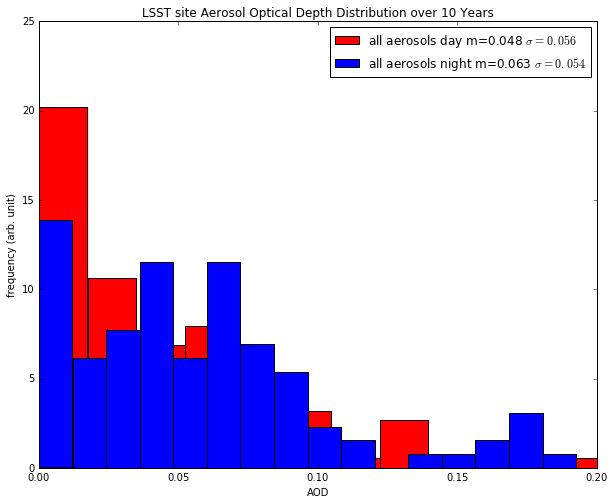

In [15]:
# Draw the histograms for AOD
#-------------------------------
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(1,1,1)

themean_aod_day=aod_day_coll.mean()
themean_aod_night=aod_night_coll.mean()
therms_aod_day=aod_day_coll.std()
therms_aod_night=aod_night_coll.std()

label_day='all aerosols day m=%4.3f $\sigma =%4.3f $' % (themean_aod_day,therms_aod_day)
label_night='all aerosols night m=%4.3f $\sigma =%4.3f $' % (themean_aod_night,therms_aod_night)

ax.hist(aod_day_coll,bins=20, facecolor='r',normed=1,label=label_day)
ax.hist(aod_night_coll,bins=20, facecolor='b',normed=1,label=label_night)
plt.xlim(0,0.2)
ax.set_ylabel('frequency (arb. unit)')
ax.set_xlabel('AOD')
title= "LSST site Aerosol Optical Depth Distribution over 10 Years"
figfilename='Images/'+filename_base+'/'+'DistTribLSSTAOD10Y.pdf' 
ax.set_title(title)
plt.legend(loc='best')
plt.savefig(figfilename, bbox_inches='tight')

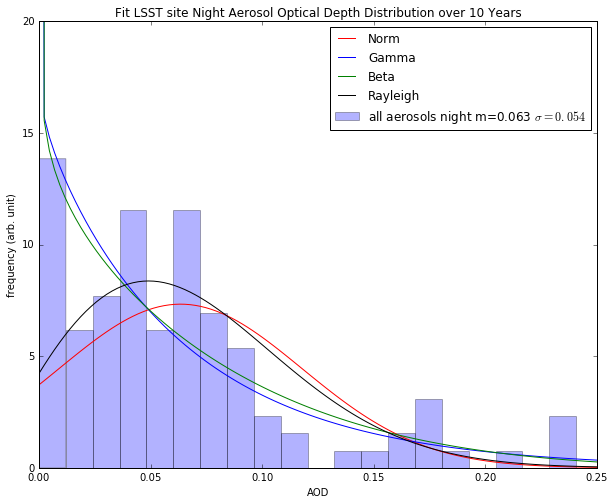

In [16]:
# Fit the night histogram for AOD
#-------------------------------

from scipy import stats  

fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(1,1,1)

hist_aod=ax.hist(aod_night_coll,bins=20,alpha=0.3,normed=1,label=label_night)


# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(aod_night_coll))

# lets try the normal distribution first
m, s = stats.norm.fit(aod_night_coll) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
ax.plot(lnspc, pdf_g,'r-' ,label="Norm") # plot it

# exactly same as above for a gamma function
ag,bg,cg = stats.gamma.fit(aod_night_coll)  
pdf_gamma = stats.gamma.pdf(lnspc, ag, bg,cg)  
ax.plot(lnspc, pdf_gamma,'b-', label="Gamma")

# exactly same as above for a beta function
ab,bb,cb,db = stats.beta.fit(aod_night_coll)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta,'g-', label="Beta")

# Rayleigh distribution
param = stats.rayleigh.fit(aod_night_coll) # distribution fitting
pdf_rayleigh = stats.rayleigh.pdf(lnspc,loc=param[0],scale=param[1])
plt.plot(lnspc, pdf_rayleigh,'k-', label="Rayleigh")

ax.set_ylim(0,20)
ax.set_xlim(0,0.25)

ax.set_ylabel('frequency (arb. unit)')
ax.set_xlabel('AOD')
title= "Fit LSST site Night Aerosol Optical Depth Distribution over 10 Years"
figfilename='Images/'+filename_base+'/'+'FitNightDistTribLSSTAOD10Y.pdf'

ax.set_title(title)
plt.legend(loc='best')
plt.savefig(figfilename, bbox_inches='tight')

plt.show()  


In [17]:
#################################################
#  will compute the chi2 of the fit for the AOD
##################################################
def ComputeChi2PerNdeg(data,model):
        data_red=data[np.where(data>0)]  # take only bins having data
        model_red=model[np.where(data>0)]                     
        N=len(data_red)  # number of bins with data
        chi2=0
        if N>1:  # at least two points          
            diff=((data_red-model_red)/np.sqrt(data_red))**2
            sum=np.sum(diff)
            chi2=sum/(N-1)
        return chi2


histdata_aod=ax.hist(aod_night_coll,bins=20,alpha=0.3,normed=0,label=label_night)
Ydata_aod=histdata_aod[0]
Xdata_aod=histdata_aod[1]
X_aod=np.zeros(len(Ydata_aod))
for i in range(0,len(Ydata_aod)):
    X_aod[i]=(Xdata_aod[i]+Xdata_aod[i+1])/2.

pdf_g_aod = stats.norm.pdf(X_aod, m, s)
pdf_gamma_aod = stats.gamma.pdf(X_aod, ag, bg,cg)
pdf_beta_aod = stats.beta.pdf(X_aod, ab, bb,cb, db) 
pdf_rayleigh_aod = stats.rayleigh.pdf(X_aod,loc=param[0],scale=param[1])

print 'chi2 for normal',ComputeChi2PerNdeg(Ydata_aod,pdf_g_aod),'m = ', m,' s=',s
print 'chi2 for gamma',ComputeChi2PerNdeg(Ydata_aod,pdf_gamma_aod),' ag = ',ag,'bg = ',bg,'cg = ',cg
print 'chi2 for beta',ComputeChi2PerNdeg(Ydata_aod,pdf_beta_aod),' ab =',ab, 'bb = ',bb,' cb= ',cb, ' db = ',db
print 'chi2 for rayleigh',ComputeChi2PerNdeg(Ydata_aod,pdf_rayleigh_aod),' ar = ',param[0],' br =',param[1]

chi2 for normal 2.43571626716 m =  0.0634343  s= 0.0544128
chi2 for gamma 1.35754674821  ag =  0.964848247482 bg =  -1.14198773407e-27 cg =  0.0677346953361
chi2 for beta 1.35072457325  ab = 0.902361293851 bb =  5.22070480926  cb=  -2.63956099488e-31  db =  0.431985731739
chi2 for rayleigh 1.90138276961  ar =  -0.0233675346376  br = 0.072459631625


## Pandas collection

In [18]:
data_dict = {'dates': data_dates, 'AOD_days': aod_day_coll, 'AOD_nights': aod_night_coll}

In [19]:
dataset=pd.DataFrame(data_dict,columns={'dates','AOD_days','AOD_nights'})

In [20]:
dataset.describe()

,AOD_nights,AOD_days
count,108.000000,108.000000
mean,0.063434,0.047681
std,0.054667,0.056759
min,0.000000,0.000000
25%,0.025109,0.008587
50%,0.054168,0.031496
75%,0.081847,0.063769
max,0.240680,0.348795


In [21]:
dataset.head()

,AOD_nights,dates,AOD_days
0,0.055314,2007-01-01,0.199667
1,0.229591,2007-02-01,0.013806
2,0.085573,2007-03-01,0.015175
3,0.027256,2007-04-01,0.250706
4,0.029809,2007-05-01,0.029994


In [22]:
dataset.tail()

,AOD_nights,dates,AOD_days
103,0.035879,2015-08-01,0.008434
104,0.057380,2015-09-01,0.037602
105,0.079566,2015-10-01,0.018963
106,0.205142,2015-11-01,0.000000
107,0.177995,2015-12-01,0.033135


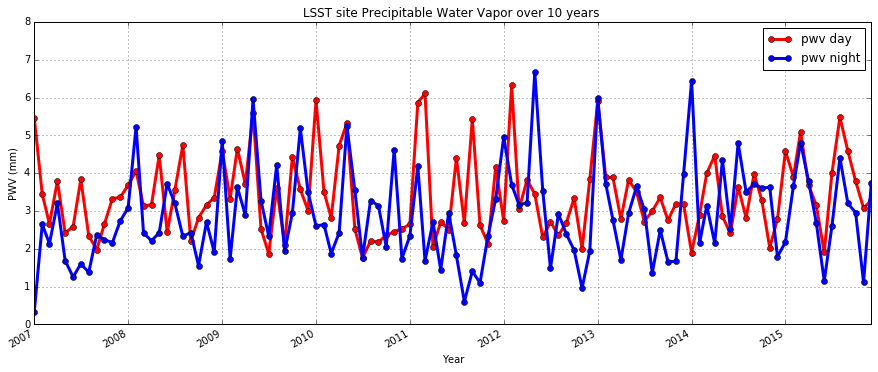

In [23]:
#########################################
# Time sequences for precipitable Water
#########################################

fig=plt.figure(figsize=(15,6))
ax=fig.add_subplot(1,1,1)


ax.plot_date(data_dates, pwv_day_coll,'ro-',label='pwv day',linewidth=3)
ax.plot_date(data_dates, pwv_night_coll,'bo-',label='pwv night',linewidth=3)


ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

title= "LSST site Precipitable Water Vapor over 10 years "
figfilename='Images/'+filename_base+'/'+'LSSTPWVvsMonth10Y.pdf' 

ax.set_ylabel('PWV (mm)')
ax.set_xlabel('Year')

ax.grid(True)
fig.autofmt_xdate()

plt.title(title)
#plt.lines.Line2D.set_linewidth(2.)
plt.ylim(0,8.)
plt.legend(loc='best')
plt.savefig(figfilename, bbox_inches='tight')

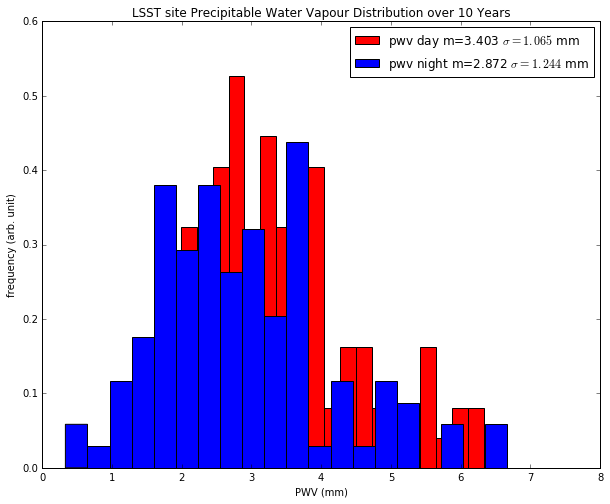

In [24]:
########################################
#
# Histograms for precipitable water
#
#######################################
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(1,1,1)

themean_pwv_day=pwv_day_coll.mean()
themean_pwv_night=pwv_night_coll.mean()
therms_pwv_day=pwv_day_coll.std()
therms_pwv_night=pwv_night_coll.std()

label_day='pwv day m=%4.3f $\sigma =%4.3f $ mm' % (themean_pwv_day,therms_pwv_day)
label_night='pwv night m=%4.3f $\sigma =%4.3f $ mm' % (themean_pwv_night,therms_pwv_night)

ax.hist(pwv_day_coll,bins=20, facecolor='r',normed=1,label=label_day)
ax.hist(pwv_night_coll,bins=20, facecolor='b',normed=1,label=label_night)
plt.xlim(0,8.0)
ax.set_ylabel('frequency (arb. unit)')
ax.set_xlabel('PWV (mm)')
title= "LSST site Precipitable Water Vapour Distribution over 10 Years"
figfilename='Images/'+filename_base+'/'+'DistTribLSSTPWV10Y.pdf'

ax.set_title(title)
plt.legend(loc='best')
plt.savefig(figfilename, bbox_inches='tight')

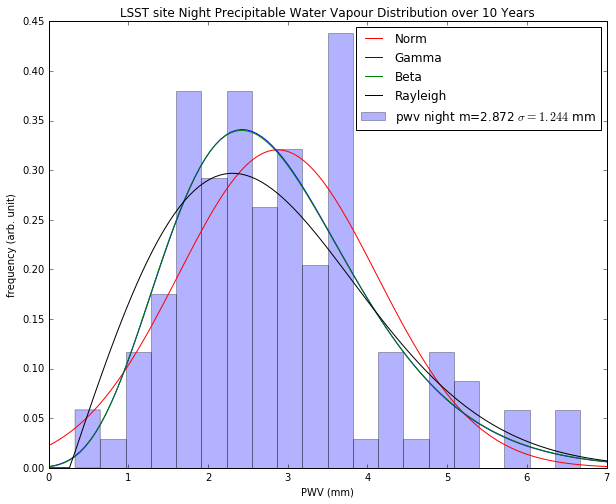

In [25]:
#####################################
# Fit the night histogram for PWV
#####################################

from scipy import stats  

fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(1,1,1)

ax.hist(pwv_night_coll,bins=20,alpha=0.3,normed=1,label=label_night);


# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(aod_night_coll))

# lets try the normal distribution first
m, s = stats.norm.fit(pwv_night_coll) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
ax.plot(lnspc, pdf_g,'r-' ,label="Norm") # plot it

# exactly same as above for a gamma function
ag,bg,cg = stats.gamma.fit(pwv_night_coll)  
pdf_gamma = stats.gamma.pdf(lnspc, ag, bg,cg)  
ax.plot(lnspc, pdf_gamma,'b-', label="Gamma")

# exactly same as above for a beta function
ab,bb,cb,db = stats.beta.fit(pwv_night_coll)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta,'g-', label="Beta")

# Rayleigh distribution
param = stats.rayleigh.fit(pwv_night_coll) # distribution fitting
pdf_rayleigh = stats.rayleigh.pdf(lnspc,loc=param[0],scale=param[1])
plt.plot(lnspc, pdf_rayleigh,'k-', label="Rayleigh")

ax.set_ylabel('frequency (arb. unit)')
ax.set_xlabel('PWV (mm)')
title= "LSST site Night Precipitable Water Vapour Distribution over 10 Years"
figfilename='Images/'+filename_base+'/'+'FitNightDistTribLSSTPWV10Y.pdf' 
ax.set_title(title)
plt.legend(loc='best')
plt.savefig(figfilename, bbox_inches='tight')

plt.show()  


In [26]:
#############################################
#  Compute the chi2 for the fits of PWV
############################################
histdata_pwv=ax.hist(pwv_night_coll,bins=20,alpha=0.3,normed=0,label=label_night)
Ydata_pwv=histdata_pwv[0]
Xdata_pwv=histdata_pwv[1]
X_pwv=np.zeros(len(Ydata_pwv))
for i in range(0,len(Ydata_pwv)):
    X_pwv[i]=(Xdata_pwv[i]+Xdata_pwv[i+1])/2.

pdf_g_pwv = stats.norm.pdf(X_pwv, m, s)
pdf_gamma_pwv = stats.gamma.pdf(X_pwv, ag, bg,cg)
pdf_beta_pwv = stats.beta.pdf(X_pwv, ab, bb,cb, db) 
pdf_rayleigh_pwv = stats.rayleigh.pdf(X_pwv,loc=param[0],scale=param[1])

print 'chi2 for normal = ',ComputeChi2PerNdeg(Ydata_pwv,pdf_g_pwv),'m = ', m,' s=',s
print 'chi2 for gamma = ',ComputeChi2PerNdeg(Ydata_pwv,pdf_gamma_pwv),' ag = ',ag,'bg = ',bg,'cg = ',cg
print 'chi2 for beta = ',ComputeChi2PerNdeg(Ydata_pwv,pdf_beta_pwv), ' ab =',ab, 'bb = ',bb,' cb= ',cb, ' db = ',db
print 'chi2 for rayleigh = ',ComputeChi2PerNdeg(Ydata_pwv,pdf_rayleigh_pwv),' ar = ',param[0],' br =',param[1]

chi2 for normal =  6.00266480956 m =  2.87249  s= 1.2444
chi2 for gamma =  5.99833941764  ag =  7.81124622135 bg =  -0.587439337093 cg =  0.442863603002
chi2 for beta =  5.9984518199  ab = 7.39115111722 bb =  855.692238951  cb=  -0.518453237361  db =  396.204584738
chi2 for rayleigh =  5.99958966478  ar =  0.264875197202  br = 2.04291933002


# Pandas collection for PWV

In [27]:
data_dict2 = {'dates': data_dates, 'PWV_days': pwv_day_coll, 'PWV_nights': pwv_night_coll}

In [28]:
dataset2=pd.DataFrame(data_dict2,columns={'dates','PWV_days','PWV_nights'})

In [29]:
dataset2.describe()

,PWV_days,PWV_nights
count,108.000000,108.000000
mean,3.403296,2.872493
std,1.069851,1.250200
min,1.756672,0.332454
25%,2.638791,1.941136
50%,3.236731,2.698967
75%,3.895812,3.614878
max,6.331009,6.668858


## Summary of data for LSST site

In [30]:
data_dict_summary = {'dates': data_dates, 'AOD_days': aod_day_coll, 'AOD_nights': aod_night_coll,'PWV_days': pwv_day_coll, 'PWV_nights': pwv_night_coll}
dataset_summary=pd.DataFrame(data_dict_summary,columns={'dates','AOD_days','AOD_nights','PWV_days','PWV_nights'})
dataset_summary=dataset_summary[['dates','AOD_days','AOD_nights','PWV_days','PWV_nights']]  # ordering columns as I want
dataset_summary.describe()

,AOD_days,AOD_nights,PWV_days,PWV_nights
count,108.000000,108.000000,108.000000,108.000000
mean,0.047681,0.063434,3.403296,2.872493
std,0.056759,0.054667,1.069851,1.250200
min,0.000000,0.000000,1.756672,0.332454
25%,0.008587,0.025109,2.638791,1.941136
50%,0.031496,0.054168,3.236731,2.698967
75%,0.063769,0.081847,3.895812,3.614878
max,0.348795,0.240680,6.331009,6.668858


In [31]:
dataset_summary.head()

,dates,AOD_days,AOD_nights,PWV_days,PWV_nights
0,2007-01-01,0.199667,0.055314,5.462354,0.332454
1,2007-02-01,0.013806,0.229591,3.444027,2.643404
2,2007-03-01,0.015175,0.085573,2.658340,2.139459
3,2007-04-01,0.250706,0.027256,3.790867,3.201135
4,2007-05-01,0.029994,0.029809,2.422375,1.689483


In [32]:
dataset_outputfile='Images/'+filename_base+'/'+'SummaryAODandPWV.csv'
dataset_summary.to_csv(dataset_outputfile)

In [33]:
saved_dataset=pd.read_csv(dataset_outputfile)

In [34]:
saved_dataset.head()

,Unnamed: 0,dates,AOD_days,AOD_nights,PWV_days,PWV_nights
0,0,2007-01-01,0.199667,0.055314,5.462354,0.332454
1,1,2007-02-01,0.013806,0.229591,3.444027,2.643404
2,2,2007-03-01,0.015175,0.085573,2.658340,2.139459
3,3,2007-04-01,0.250706,0.027256,3.790867,3.201135
4,4,2007-05-01,0.029994,0.029809,2.422375,1.689483
